## Overview

The Matrix Linear Model serves as a simple yet robust multivariate framework for encoding relationships and groupings within high-throughput data. Its flexibility allows it to encode both categorical and continuous relationships, thereby enhancing the detection of associations between responses and predictors.

Within the scope of the matrix linear model framework, the model is articulated as follows:

$$Y = XBZ^T+E$$

Where 
- $Y_{n \times m}$ is the response matrix
- $X_{n \times p}$ is the matrix for main predictors,
- $Z_{m \times q}$ denote the response attributes matrix based on a supervised knowledge,
- $E_{n \times m}$ is the error term, 
- $B_{p \times q}$ is the matrix for main and interaction effects.


## Basic Usage

In this section, we demonstrate how to utilize `MatrixLM.jl` via a simple example that involves simulated data. 

### Data Generation

To enhance the practibality of this example, we assume that both the responses and the predictors are presented as dataframes. 
Our dataset consists of a dataframe `X`, which includes `p = 5` predictors. Among these predictors, two are categorical variables and three are numerical, spread across `n = 100` samples. We then consider a response dataframe `Y` composed of `m = 250` responses. To simulate the `Y` data, we need to generate the matrices `Z`,`B`, and `E`. 
The matrix `Z` provides information about the response population, which corresponds to the `Y`'s columns $y_{i \in [1, 250]}$. The dimensions of this matrix are set at `250x10`.
Given this setup, the coefficient matrix `B` is designed to have dimensions of `5x10`. This matches the number of predictors in `X` and the information categories in `Z`. Finally, we create the noise matrix `E`, which contains the error terms. We generate this matrix as a normally-distributed matrix ($N, 0, 1$), adding a layer of randomness to our simulation.


In [1]:
using MatrixLM, DataFrames, Random, Plots, StatsModels, Statistics
Random.seed!(1)

# Dimensions of matrices 
n = 100
m = 250

# Number of groupings designed in the Z matrix
q = 10

# Generate data with two categorical variables and 3 numerical variables.
dfX = hcat(
    DataFrame(catvar1=string.(rand(0:1, n)), catvar2=rand(["A", "B", "C", "D"], n)), 
    DataFrame(rand(n,3), ["var3", "var4", "var5"])
    );

[ Info: Precompiling MatrixLM [37290134-6146-11e9-0c71-a5c489be1f53]


Let use the function `design_matrix()` to get the predictor model matrix based on the formula expression including all the variables terms.

In [42]:
# Convert dataframe to predicton matrix
X = design_matrix(@mlmformula(catvar1 + catvar2 + var3 + var4 + var5), dfX)

p = size(X)[2];

We also have the option to specify contrast coding in your model. For a detailed understanding of how to implement contrast coding, please refer to the documentation for [contrast coding with StatsModels.jl](https://juliastats.org/StatsModels.jl/stable/contrasts/#How-to-specify-contrast-coding). This will provide you with comprehensive instructions and examples.

In [84]:
# Convert dataframe to predicton matrix
my_ctrst = Dict(
             :catvar1 => DummyCoding(base = "0"),
             :catvar2 => DummyCoding(base = "A")
           )
           
X = design_matrix(@mlmformula(catvar1 + catvar2 + var3 + var4 + var5), dfX, my_ctrst);

Randomly generate some data for column covariates `Z` and the error materix `E`:

In [44]:
Z = rand(m,q);
E = randn(n,m);


Next, we will structure the coefficient matrix B following a specific pattern. This approach will facilitate a more effective visualization of the results in the subsequent steps:

In [50]:
(p,q)
B = [
    2.0   3.0   4.0   5.0  6.0  7.0  8.0  0.0 0.5 -2.0;
    0.01  0.02  0.01  0.09 0.18 0.03 0.14 0.0 0.5 -2.0;
    -1.0  -0.5  0.02  0.49 1.1  2.0  5.0  0.0 0.5 -2.0;
    -0.01 0.02  -0.01 3.0  3.0  7.0  0.14 0.0 0.5 -2.0;
    0.0   0.0   0.0   0.0  3.0  3.0  3.0  3.0 0.5 -2.0;
    3.0   3.0   3.0   3.0  0.08 0.03 0.0  0.0 0.5 -2.0;
    0.01  0.0   3.0   3.0  3.0  3.0 0.04  0.0 0.5 -2.0;
];

Generate the response matrix `Y`:

In [89]:
Y = X*B*Z' + E;

Now, construct the `RawData` object consisting of the response variable `Y` and row/column predictors `X` and `Z`. All three matrices must be passed in as 2-dimensional arrays.

In [95]:
# Construct a RawData object
dat = RawData(Response(Y), Predictors(X, Z));

### Model estimation

Least-squares estimates for matrix linear models can be obtained by running `mlm`. An object of type `Mlm` will be returned, with variables for the coefficient estimates (`B`), the coefficient variance estimates (`varB`), and the estimated variance of the errors (`sigma`). By default, `mlm` estimates both row and column main effects (X and Z intercepts), but this behavior can be suppressed by setting `addXIntercept=false` and/or `addZIntercept=false`. Column weights for `Y` and the target type for variance shrinkage<sup>[1](#myfootnote1)</sup> can be optionally supplied to `weights` and `targetType`, respectively. 

In [91]:
est = mlm(dat; addXIntercept=false, addZIntercept=false); # Model estimation

### Model predictions and residuals

The coefficient estimates can be accessed using `coef(est)`. Predicted values and residuals can be obtained by calling `predict()` and `resid()`. By default, both of these functions use the same data used to fit the model. However, a new `Predictors` object can be passed into `predict()` as the `newPredictors` argument and a new `RawData` object can be passed into `resid()` as the newData argument. For convenience, `fitted(est)` will return the fitted values by calling predict with the default arguments.

In [92]:
esti_coef = coef(est); # Get the coefficients of the model

To compare the estimated coefficients with the original matrix `B`, we will visualize the matrices using heatmaps. This graphical representation allows us to readily see differences and similarities between the two.

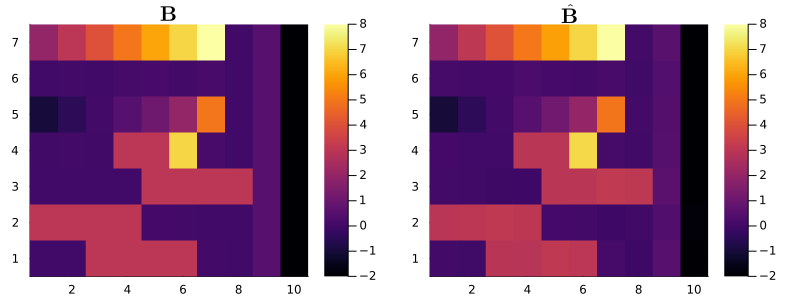

In [93]:
plot(
    heatmap(B[end:-1:1, :], 
            size = (800, 300)),     
    heatmap(esti_coef[end:-1:1, :], 
            size = (800, 300), 
            clims = (-2, 8)),     
    title = ["\$ \\mathbf{B}\$" "\$ \\mathbf{\\hat{B}}\$"]
)



Let's employ the same visualization method to compare the predicted values with the original `Y` response matrix. This allows us to gauge the accuracy of our model predictions.

In [97]:
preds = predict(est); # Prediction value

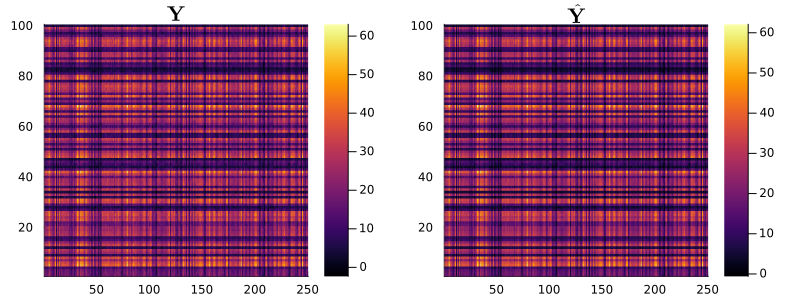

In [104]:
plot(
    heatmap(Y[end:-1:1, :], 
            size = (800, 300)),     
    heatmap(preds.Y[end:-1:1, :], 
            size = (800, 300), 
            # clims = (-2, 8)
            ),     
    title = ["\$ \\mathbf{Y}\$" "\$ \\mathbf{\\hat{Y}}\$"]
)

The `resid()` function, available in `MatrixLM.jl`, provides us with the ability to compute residuals for each observation, helping you evaluate the discrepancy between the model's predictions and the actual data.

In [114]:
resids = resid(est);

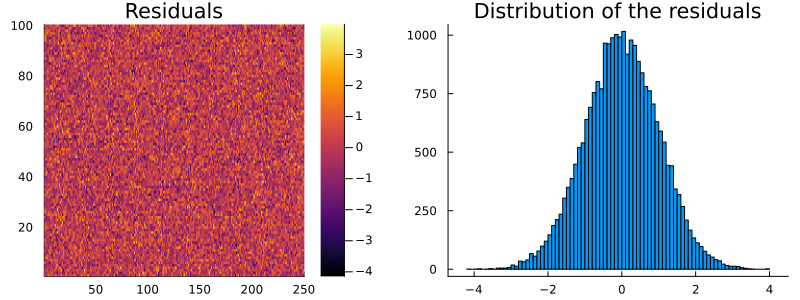

In [113]:
plot(
    heatmap(resids[end:-1:1, :], 
            size = (800, 300)),     
    histogram(
        (reshape(resids,250*100,1)),
            grid  = false,
            label = "",
            size = (800, 300)),     
    title = ["Residuals" "Distribution of the residuals"]
)

### T-statistics and permutation test

The t-statistics for an `Mlm` object (defined as `est.B ./ sqrt.(est.varB)`) can be obtained by running `t_stat`. By default, `t_stat` does not return the corresponding t-statistics for any main effects that were estimated by `mlm`, but they will be returned if `isMainEff=true`.

In [116]:
tStats = t_stat(est);

Permutation p-values for the t-statistics can be computed by the `mlm_perms` function. `mlm_perms` calls the more general function `perm_pvals` and will run the permutations in parallel when possible. The illustrative example below only runs 5 permutations, but a different number can be specified as the second argument. By default, the function used to permute `Y` is `shuffle_rows`, which shuffles the rows for `Y`. Alternative functions for permuting `Y`, such as `shuffle_cols`, can be passed into the argument `permFun`. `mlm_perms` calls `mlm` and `t_stat` , so the user is free to specify keyword arguments for `mlm` or `t_stat`; by default, `mlm_perms` will call both functions using their default behavior.

In [117]:
nPerms = 500
tStats, pVals = mlm_perms(dat, nPerms);

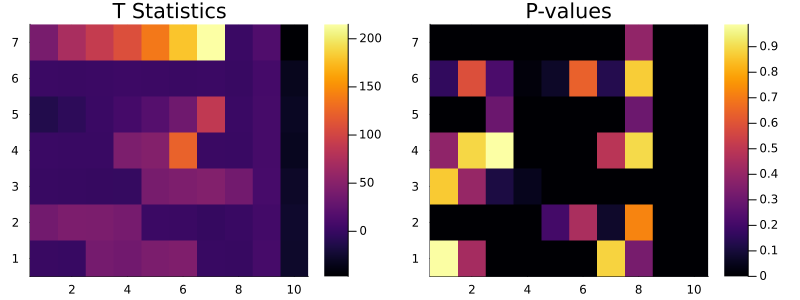

In [120]:
plot(
    heatmap(tStats[end:-1:1, :], 
            size = (800, 300)),  
    heatmap(pVals[end:-1:1, :], 
            size = (800, 300)),       
    title = ["T Statistics" "P-values"]
)

---

<a name="myfootnote1">1</a>. Ledoit, O., & Wolf, M. (2003). Improved estimation of the covariance matrix of stock returns with an application to portfolio selection. Journal of empirical finance, 10(5), 603-621. 